In [290]:
# Gregor von Laszewski laszewski@gmail.com

In [291]:

from cloudmesh.common.util import readfile
from glob import glob
from cloudmesh.common.Shell import Shell
import sys
from io import StringIO
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

files = glob("outputs/*.out")

print (files)

['outputs/simple-v100-thf2bn-51363727.out', 'outputs/v100-thf2bn-51363728.out', 'outputs/a100-fox-thf2bn-51363720.out', 'outputs/a100-thf2bn-51363737.out', 'outputs/p100-thf2bn-51363724.out', 'outputs/a100-pod-thf2bn-51363721.out', 'outputs/a100-fox-thf2bn-51363738.out', 'outputs/rtx2080-thf2bn-51363725.out', 'outputs/k80-thf2bn-51363723.out', 'outputs/rtx3090-thf2bn-51363726.out']


In [292]:
def get(value):
    return float(df[df['timer'] == value]["time"])


data = []

for filename in files:
    print (filename)
    content = readfile(filename)
    lines = Shell.find_lines_from(content, "# inference")
    lines = Shell.find_lines_with(lines, "# csv")
    content = "\n".join(lines)
    try:
        #print (content)
        # df = pd.read_csv(content)
        df = pd.read_csv(StringIO(content), sep=",")
        df = df.drop(columns=["# csv", "status", "sum", "start", "uname.node", "user",
                              "uname.system", "platform.version", "msg", "tag"])
        for exclude in ["init",'number_of_ranks', "number_of_nodes", "version",
                        "result", "run_stop", "submission_status"]:
            df = df[df['timer'] != exclude]
        # df = df.drop(rows=["init"])

        df['time'] = df['time'].astype(float)

        total = get("total")
        training = get("training block")
        inference = get("inference block")

        #df[["rest"]] = ["rest", 0.0]

        rest = total - training - inference
        rest_row = pd.DataFrame([{'timer':'rest', 'time': rest}])

        df = pd.concat([df, rest_row], ignore_index=True)
        # df = pd.concat([rest_row,df.loc[:]]).reset_index(drop=True)

        df[["job"]] = filename.replace(".out","").replace("outputs/", "")
        df = df.reset_index()
        df = df.drop(columns=["index"])
        #display(df)
        #print (total, training, inference)
        df.reset_index(drop=True, inplace=True)
        data.append(df)
    except:
        print(f"ERROR: {filename}")

outputs/simple-v100-thf2bn-51363727.out
ERROR: outputs/simple-v100-thf2bn-51363727.out
outputs/v100-thf2bn-51363728.out
ERROR: outputs/v100-thf2bn-51363728.out
outputs/a100-fox-thf2bn-51363720.out
outputs/a100-thf2bn-51363737.out
outputs/p100-thf2bn-51363724.out
outputs/a100-pod-thf2bn-51363721.out
ERROR: outputs/a100-pod-thf2bn-51363721.out
outputs/a100-fox-thf2bn-51363738.out
outputs/rtx2080-thf2bn-51363725.out
ERROR: outputs/rtx2080-thf2bn-51363725.out
outputs/k80-thf2bn-51363723.out
outputs/rtx3090-thf2bn-51363726.out


In [293]:
data = pd.concat(data, ignore_index=True)
data

,timer,time,job
0,total,955.439,a100-fox-thf2bn-51363720
1,training block,752.782,a100-fox-thf2bn-51363720
2,training,752.768,a100-fox-thf2bn-51363720
3,loaddata,3.142,a100-fox-thf2bn-51363720
4,training_on_mutiple_GPU,747.875,a100-fox-thf2bn-51363720
5,inference block,202.443,a100-fox-thf2bn-51363720
6,inference,0.022,a100-fox-thf2bn-51363720
7,load model,0.454,a100-fox-thf2bn-51363720
8,read inference files,0.009,a100-fox-thf2bn-51363720
9,rest,0.214,a100-fox-thf2bn-51363720


In [294]:
def simplify_job(name):
   return " ".join(name.split("-")[:-2]).replace("fox", "special")


def get_by_timer(data, timer):
    d = data[data['timer'] == timer]
    d = d.reset_index()
    d["job"] = d["job"].apply(simplify_job)
    d = d.drop(columns=["index"])
    return d

total = get_by_timer(data, "total")

total

,timer,time,job
0,total,955.439,a100 special
1,total,712.589,a100
2,total,1012.015,p100
3,total,710.565,a100 special
4,total,1553.553,k80
5,total,713.581,rtx3090


In [318]:
"""
+-------------------------+----------+---------+
| Name                    | Status   |    Time |
|-------------------------+----------+---------+
| total                   | ok       | 203.461 |
| init                    | ok       |   0     |
| number_of_ranks         | ok       |   0     |
| number_of_nodes         | ok       |   0     |
| version                 | ok       |   0     |
| training block          | ok       | 152.313 |
| training                | ok       | 152.299 |
| loaddata                | ok       |   1.766 |
| training_on_mutiple_GPU | ok       | 148.641 |
| inference block         | ok       |  51.018 |
| inference               | ok       |   0.006 |
| load model              | ok       |   0.196 |
| read inference files    | ok       |   0.009 |
| result                  | ok       |   0     |
| run_stop                | ok       |   0     |
| submission_status       | ok       |   0     |
+-------------------------+----------+---------+
"""

desktop_row = pd.DataFrame([{'timer':'total', 'time': 203.461, 'job': 'rtx3090 desktop'}])

total = pd.concat([total, desktop_row], ignore_index=True)
total

,timer,time,job
0,total,1553.553,k80
1,total,1012.015,p100
2,total,955.439,a100 special
3,total,713.581,rtx3090
4,total,712.589,a100
5,total,710.565,a100 special
6,total,203.461,rtx3090 desktop
7,total,203.461,rtx3090 desktop


In [319]:
total = total.sort_values(by=['time'], ascending=False)

In [320]:
def save_image(p, name, dpi=300):
    # Shell.mkdir(directory)
    p.figure.savefig(f"{name}.svg", bbox_inches="tight")
    p.figure.savefig(f"{name}.png", bbox_inches="tight", dpi=dpi)
    p.figure.savefig(f"{name}.pdf", bbox_inches="tight")
    p.figure.savefig(f"{name}.tiff", bbox_inches="tight")

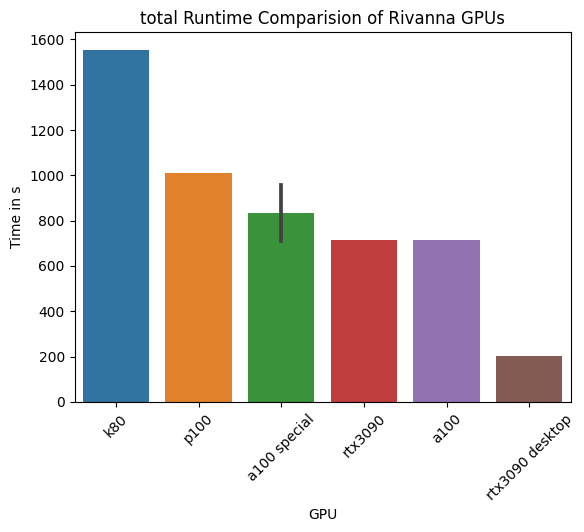

In [321]:
def plot_by_timer(data, timer):
    plt.xticks(rotation=45)
    p = sns.barplot(data, x="job", y="time")
    p.set(xlabel = "GPU", ylabel = "Time in s")
    p.set_title(f"{timer} Runtime Comparision of Rivanna GPUs")
    return p

p = plot_by_timer(total, "total")

In [322]:
save_image(p, "./images/comparision-epoch-1", dpi=300)

,timer,time,job
0,training block,752.782,a100 special
1,training block,570.136,a100
2,training block,809.291,p100
3,training block,508.140,a100 special
4,training block,1230.923,k80
5,training block,571.083,rtx3090


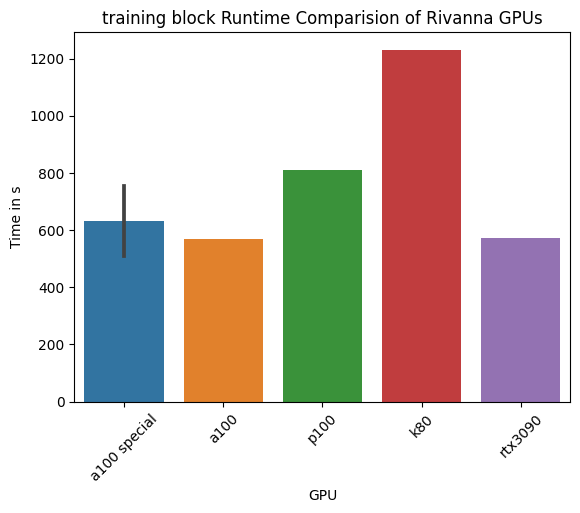

In [300]:
training = get_by_timer(data, "training block")
plot_by_timer(training, "training block")

training

,timer,time,job
0,inference block,202.443,a100 special
1,inference block,142.258,a100
2,inference block,202.494,p100
3,inference block,202.208,a100 special
4,inference block,322.377,k80
5,inference block,142.286,rtx3090


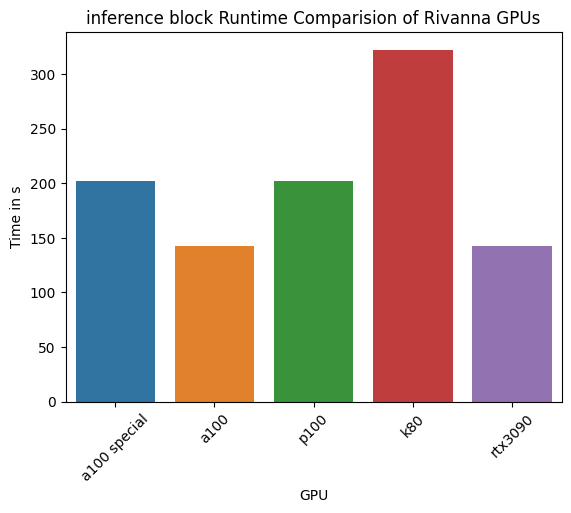

In [301]:
inference = get_by_timer(data, "inference block")
plot_by_timer(inference, "inference block")

inference

In [302]:

_data = data[data['timer'].isin(["total","training block","inference block"])]
_data = _data.sort_values(by=['time'], ascending=False)
_data = _data.reset_index()
_data["job"] = _data["job"].apply(simplify_job)
_data = _data.drop(columns=["index"])

# _data["job"] = _data["job"].apply(simplify_job)
# _data = _data.drop(columns=["index"])

_data

,timer,time,job
0,total,1553.553,k80
1,training block,1230.923,k80
2,total,1012.015,p100
3,total,955.439,a100 special
4,training block,809.291,p100
5,training block,752.782,a100 special
6,total,713.581,rtx3090
7,total,712.589,a100
8,total,710.565,a100 special
9,training block,571.083,rtx3090


In [303]:
def get(name):
    content = data[data.timer.isin([name])]['time'].tolist()
    return {name: content}


#plt.xticks(rotation=45)
#p.set(xlabel = "GPU", ylabel = "Time in s")
#p.set_title("Runtime Comparision of Rivanna GPUs")


stacked = pd.DataFrame(
    [get['job'], get('total'), get('training block')]
)

stacked

#stacked.set_index('job').plot(kind='bar', stacked=True, color=['blue', 'red', 'orange'])

TypeError: 'function' object is not subscriptable